# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Use SFrames to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

In [1]:
%matplotlib inline

In [2]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn import tree

# Load LendingClub dataset

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/). A parsed and cleaned form of the dataset is availiable [here](https://github.com/learnml/machine-learning-specialization-private). Make sure you **download the dataset** before running the following command.

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [4]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'bad_loans'                  # 1 means a risky (bad) loan 0 means a safe loan
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

In [5]:
loans = pd.read_csv('./data/lending-club-data.csv', usecols=features)
loans.head()

,term,grade,sub_grade,home_ownership,purpose,dti,revol_util,total_rec_late_fee,bad_loans,emp_length_num,short_emp,last_delinq_none,last_major_derog_none
0,36 months,B,B2,RENT,credit_card,27.65,83.7,0.00,0,11,0,1,1
1,60 months,C,C4,RENT,car,1.00,9.4,0.00,1,1,1,1,1
2,36 months,C,C5,RENT,small_business,8.72,98.5,0.00,0,11,0,1,1
3,36 months,C,C1,RENT,other,20.00,21.0,16.97,0,11,0,0,1
4,36 months,A,A4,RENT,wedding,11.20,28.3,0.00,0,4,0,1,1


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [6]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 13 columns):
term                     122607 non-null object
grade                    122607 non-null object
sub_grade                122607 non-null object
home_ownership           122607 non-null object
purpose                  122607 non-null object
dti                      122607 non-null float64
revol_util               122607 non-null float64
total_rec_late_fee       122607 non-null float64
bad_loans                122607 non-null int64
emp_length_num           122607 non-null int64
short_emp                122607 non-null int64
last_delinq_none         122607 non-null int64
last_major_derog_none    122607 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 12.2+ MB


Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

In [7]:
loans['grade'].value_counts(dropna=False)

B    37172
C    29950
A    22314
D    19175
E     8990
F     3932
G     1074
Name: grade, dtype: int64

In [8]:
loans['sub_grade'].value_counts(dropna=False)

B3    9036
B4    8279
B2    7096
C1    7068
B5    6924
C2    6726
A5    6027
A4    5993
B1    5837
C3    5690
C4    5402
C5    5064
D1    4593
D2    4391
A3    3955
D3    3745
D4    3489
A2    3352
A1    2987
D5    2957
E2    2184
E1    2080
E3    1785
E4    1581
E5    1360
F1    1105
F2     930
F3     770
F4     629
F5     498
G1     370
G2     241
G3     167
G4     152
G5     144
Name: sub_grade, dtype: int64

We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `sub_grade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

In [9]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    59240
RENT        53245
OWN          9943
OTHER         179
Name: home_ownership, dtype: int64

This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

In [10]:
loans['purpose'].value_counts(dropna=False)

debt_consolidation    68233
credit_card           22050
other                  9087
home_improvement       7543
major_purchase         3877
small_business         3264
car                    2375
medical                1607
wedding                1526
moving                 1180
house                  1005
vacation                860
Name: purpose, dtype: int64

In [11]:
loans['term'].value_counts(dropna=False)

 36 months    97801
 60 months    24806
Name: term, dtype: int64

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column 1 means a risky (bad) loan 0 means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [12]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop(['bad_loans'], axis=1, inplace=True)

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

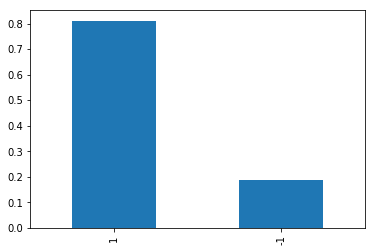

In [13]:
loans['safe_loans'].value_counts(dropna=False, normalize=True).plot(kind='bar')
pass

You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

Follow the following steps:

- Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see \#7 for implementation hints.
- Load the JSON files into the lists train_idx and validation_idx.
- Perform train/validation split using train_idx and validation_idx.

## One-hot encoding

For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. The next assignment has more details about this.

In [14]:
loans_data = pd.get_dummies(loans)
loans_data.columns

Index(['dti', 'revol_util', 'total_rec_late_fee', 'emp_length_num',
       'short_emp', 'last_delinq_none', 'last_major_derog_none', 'safe_loans',
       'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A1',
       'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5',
       'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4',
       'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3',
       'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2',
       'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1',
       'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5',
       'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4',
       'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3',
       'sub_grade_G4', 'sub_grade_G5', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.

One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset.

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Split data into training and validation sets

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [15]:
idx_train = pd.read_json('./data/module-5-assignment-1-train-idx.json', typ='series').tolist()
idx_validation = pd.read_json('./data/module-5-assignment-1-validation-idx.json', typ='series').tolist()

In [16]:
train_data = loans_data.iloc[idx_train,:]
validation_data = loans_data.iloc[idx_validation,:]

In [17]:
train_X = train_data.loc[:, train_data.columns!='safe_loans'].values
train_y = train_data.safe_loans.values

In [18]:
valid_X = validation_data.loc[:, validation_data.columns!='safe_loans'].values
valid_y = validation_data.safe_loans.values

# Use decision tree to build a classifier

Now, let's use the built-in scikit learn decision tree learner ([sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

Note: You will have to first convert the SFrame into a numpy data matrix, and extract the target labels as a numpy array (Hint: you can use the .to_numpy() method call on SFrame to turn SFrames into numpy arrays). See the API for more information. Make sure to set max_depth=6.

Call this model decision_tree_model.

In [19]:
decision_tree_model = tree.DecisionTreeClassifier(max_depth=6).fit(X=train_X, y=train_y)

Also train a tree using with max_depth=2. Call this model small_model.

In [20]:
small_model = tree.DecisionTreeClassifier(max_depth=2).fit(X=train_X, y=train_y)

## Visualizing a learned model

For this optional section, we would like to see what the small learned tree looks like. If you are using scikit-learn and have the package [Graphviz](http://graphviz.readthedocs.org/en/latest/#), then you will be able to perform this section. If you are using a different software, try your best to follow along.

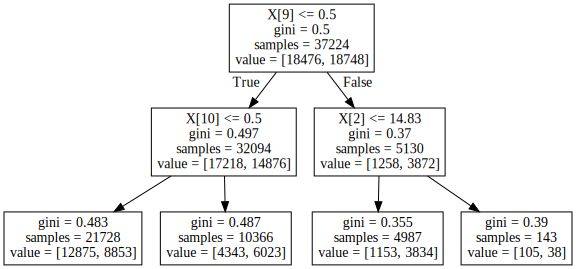

In [21]:
dot_data = tree.export_graphviz(small_model, out_file=None)
graph = graphviz.Source(dot_data)
graph

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [22]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)

## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [23]:
sample_X = sample_validation_data.loc[:, sample_validation_data.columns!='safe_loans'].values
sample_yhat = decision_tree_model.predict(sample_X)

In [24]:
print(np.sum(sample_yhat == sample_validation_data.safe_loans) / sample_yhat.size)

0.5


## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** if you are using scikit-learn, you can use the .predict_proba() method,

In [25]:
sample_probhat = decision_tree_model.predict_proba(sample_X)[:,1]
print(sample_probhat)

[0.65843457 0.46369354 0.35249042 0.79210526]


In [26]:
print(sample_probhat >= 0.5)
print(sample_yhat)

[ True False False  True]
[ 1 -1 -1  1]


### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

In [27]:
small_model.predict_proba(sample_X)[:,1]

array([0.58103415, 0.40744661, 0.40744661, 0.76879888])

**Quiz Question:** Notice that the probability preditions are the **exact same** for the 2nd and 3rd loans. Why would this happen?

## Visualize the prediction on a tree


Note that you should be able to look at the small tree, traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [28]:
sample_validation_data.iloc[1, [2,9,10]]

total_rec_late_fee    0.0
term_ 60 months       0.0
grade_A               0.0
Name: 79, dtype: float64

Let's visualize the small tree here to do the traversing for this data point.

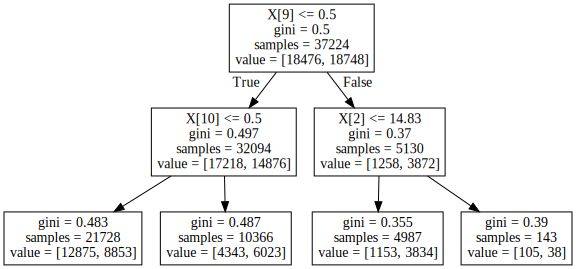

In [29]:
graph

In [30]:
small_model.predict(sample_X)[1]

-1

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [31]:
print(small_model.score(X=train_X, y=train_y))
print(decision_tree_model.score(X=train_X, y=train_y))

0.6135020416935311
0.6405276165914464


**Checkpoint:** You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

In [32]:
print(small_model.score(X=valid_X, y=valid_y))
print(decision_tree_model.score(X=valid_X, y=valid_y))

0.6193451098664369
0.6361482119775959


## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [33]:
big_model = tree.DecisionTreeClassifier(max_depth=10).fit(X=train_X, y=train_y)

Now, let us evaluate **big_model** on the training set and validation set.

In [34]:
print(big_model.score(X=train_X, y=train_y))
print(big_model.score(X=valid_X, y=valid_y))

0.6637921770900495
0.6263464024127531


### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [35]:
predictions = decision_tree_model.predict(valid_X)

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [36]:
FP = np.sum((predictions == +1) & (valid_y == -1))

**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [37]:
FN = np.sum((predictions == -1) & (valid_y == +1))

**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [38]:
print(1e4 * FN + 2e4 * FP)

50390000.0
